# Analysis of Munich Datasets

## Imports

To process our data, first of all, we import libraries:

In [492]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import numpy as np
import seaborn as sns

### Import CSV files into variables

In [493]:
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"
muc_2023 = "./munich2023.csv"

### Create the Data Frames from the CSV files

In [494]:
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)
df_muc_2023 = pd.read_csv(muc_2023)

In [495]:
# df_muc_2023.head()
## Here we see that or 2023 the format of the "datum" column (yyyy.mm.dd) is different to the one of the other years "yyyy-mm-dd"

In [496]:
## So we change the '.' for '-'
df_muc_2023['datum'] = df_muc_2023['datum'].str.replace('.','-')
## We also need to change the name of the min and max temp
df_muc_2023.rename(columns={'min-temp':'min.temp', 'max-temp':'max.temp'}, inplace=True)
# df_muc_2023.info()

And the summary information:

In [497]:
df_munich = pd.concat([df_muc_2016,df_muc_2017,df_muc_2018,df_muc_2019,df_muc_2020,df_muc_2021,df_muc_2022,df_muc_2023], ignore_index=True)

# Since all the values of the column Uhrzeit start and end are always the same, they are not really needed for the analysis, we then will drop these columns
# List of columns to drop
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende']

# Drop the specified columns
df_munich_v2 = df_munich.drop(columns=columns_to_drop)
df_munich_v2 = df_munich_v2.sort_values(by='datum')
df_munich_v2.info()
df_munich_v2.to_csv('munich_bikes.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 17317 entries, 0 to 17316
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datum          17317 non-null  object 
 1   zaehlstelle    17317 non-null  object 
 2   richtung_1     16873 non-null  float64
 3   richtung_2     16873 non-null  float64
 4   gesamt         16873 non-null  float64
 5   min.temp       17317 non-null  float64
 6   max.temp       17317 non-null  float64
 7   niederschlag   17317 non-null  float64
 8   bewoelkung     17317 non-null  int64  
 9   sonnenstunden  17317 non-null  float64
 10  kommentar      434 non-null    object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.6+ MB


# Time Series Analysis
**_Check the following link https://medium.com/gitconnected/mastering-time-series-analysis-from-scratch-a-data-scientists-roadmap-437ff673df72_**

- Time series data is data collected on the same subject at different points in time.
- Time-series analysis isn't about predicting the future; instead, it's about understanding the past.
- Key methodologies used in time-series analysis include moving averages, exponential smoothing, and decomposition methods. 
- Methods such as Autoregressive Integrated Moving Average (ARIMA) models also fall under this category.
- The “time” element in time-series data means that the data is ordered by time. In this type of data, each entry is preceded and followed by another and has a timestamp that determines the order of the data. 

## Time-series components

To correctly analyze time-series data, we need to look to the four components of a time series:
- Trend: this is a long-term movement of the time series, such as the decreasing average heart rate of workouts as a person gets fitter.
- Seasonality: regular periodic occurrences within a time interval smaller than a year (e.g., higher step count in spring and autumn because it’s not too cold or too hot for long walks).
- Cyclicity: repeated fluctuations around the trend that are longer in duration than irregularities but shorter than what would constitute a trend. In our walking example, this would be a one-week sightseeing holiday every four to five months.
- Irregularity: short-term irregular fluctuations or noise, such as a gap in the sampling of the pedometer or an active team-building day during the workweek.

Trend and seasonality are deterministic, whereas cyclicity and irregularities are not.

### Time Series Forecasting
- Time series forecasting is exactly what it sounds like; predicting unknown values. Time series forecasting involves the collection of historical data, preparing it for algorithms to consume, and then predicting the future values based on patterns learned from the historical data.

# Munich Data Set
## Introduction

In [498]:
# For this part, I am using the data sets downloaded from the Open Data site from the City of Munich (Germany)
# which I have previously imported into this Notebook in the previous steps
# I have downloaded data sets from each year since 2016 until 2023, calling them munichYYYY.csv
# These datasets record the number of bicicles that had gone trough a each of the 6 locations in Munich per day, the weather that day, hours of sun, and the direction the bikers were traveling
# the Dates are formated as year-month-day
# Adding together all data sets into a unified one, the data set munich_bikes.csv spans from January 1st, 2016 until December 31st, 2023
# The objective is to predict the number of bikes counted daily for the first month of 2024 (and live?)
# This means that the past data (from the downloaded datasets) needs to be used to identify trends and patterns.

## Visualize first and last 5 rows, to understand the range and structure of the data
#df_munich_v2.head(), df_munich_v2.tail()

- Examine: is there any apparent trend in the data?
- Multivariate time series dataset
- Creation of model that enables forecasting the number of bikes

In [499]:
## The date should be our index, but we have several locations. How do we deal with this?
### ---> We could aggregate all the locations and create a total for the whole city, or
### ---> We could divide the munich_bikes.csv dataset into different datasets, depending on the location
#
#
#
## Also, we are dealing with multivariate time series dataset
## for now, we can try to analyze it as if ot would just depend on one variable

## Munich - All locations summarized to one row per day

In [500]:
# Assign values of dataset to a new dataframe variable
df_munich_all_locations = df_munich_v2

# Drop columns that are not needed
df_munich_all_locations = df_munich_all_locations.drop(['zaehlstelle', 'richtung_1', 'richtung_2', 'kommentar'], axis=1)
df_munich_all_locations.info()

## df_munich_all_locations = df_munich_all_locations.groupby('datum')['gesamt'].sum()

# Group by 'datum' and aggregate the rest of the columns
df_munich_all_locations = df_munich_all_locations.groupby('datum').agg({
    'gesamt': 'sum',  # Sum of 'gesamt' column
    'min.temp': 'first',  # Take the first value of 'min.temp'
    'max.temp': 'first',  # Take the first value of 'max.temp'
    'niederschlag': 'first',  # Take the first value of 'niederschlag'
    'bewoelkung': 'first',  # Take the first value of 'bewoelkung'
    'sonnenstunden': 'first'  # Take the first value of 'sonnenstunden'
}).reset_index()  # Reset the index to make 'datum' a column again

# print(df_munich_all_locations)

<class 'pandas.core.frame.DataFrame'>
Index: 17317 entries, 0 to 17316
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datum          17317 non-null  object 
 1   gesamt         16873 non-null  float64
 2   min.temp       17317 non-null  float64
 3   max.temp       17317 non-null  float64
 4   niederschlag   17317 non-null  float64
 5   bewoelkung     17317 non-null  int64  
 6   sonnenstunden  17317 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


## Importance of Chronological Order in Time Series
When dealing with time series data, maintaining the chronological order of the data is of great importance. 
This chronological sequence is not just a feature of the dataset; it’s a fundamental aspect of time series analysis. 
This order is intrinsic to the nature of the data and crucial for accurate analysis.

By setting the date column as the index of our DataFrame, we have effectively locked in this chronological order. The index, now a time-based sequence, becomes immutable in terms of its order. This is a critical step in preserving the integrity of the time series data.

The decision to use the date as the index in our DataFrame is not just a matter of convenience; it’s a strategic choice that preserves the chronological order of the data, enabling us to leverage the full potential of time series analysis techniques.

### - Focus on "univariate" time series analysis: we want to understand and predict number of bikes as it changes day by day throughout the year

In [501]:
# Converting the 'Datum' column to datetime 
## This modification is a crucial step in time series analysis, as it allows us to leverage the temporal aspect of the data effectively.

df_munich_all_locations['datum'] = pd.to_datetime(df_munich_all_locations['datum'])

# Add columns for DayOfWeek and DayOfWeek_name
df_munich_all_locations['DayOfWeek'] = df_munich_all_locations['datum'].dt.weekday
df_munich_all_locations['DayOfWeek_name'] = df_munich_all_locations['datum'].dt.day_name()

# Setting it as the intex of the df
df_munich_all_locations.set_index('datum', inplace=True)

# Check the modified df
# df_munich_all_locations.head()
# Assuming 'column_to_drop' is the name of the column you want to drop
df_munich_all_locations.drop(columns=['bewoelkung', 'sonnenstunden'], inplace=True)


# print(df_munich_all_locations)
df_munich_all_locations.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2016-01-01 to 2023-12-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gesamt          2922 non-null   float64
 1   min.temp        2922 non-null   float64
 2   max.temp        2922 non-null   float64
 3   niederschlag    2922 non-null   float64
 4   DayOfWeek       2922 non-null   int32  
 5   DayOfWeek_name  2922 non-null   object 
dtypes: float64(4), int32(1), object(1)
memory usage: 148.4+ KB


In [502]:
def dataframe_report(df):
    info = pd.DataFrame(index=df.columns,
                         columns = ['Dtype', 
                                    'Missing values (nb)', 
                                    'Missing values (%)',
                                    'Unique values (nb)',
                                    'Unique values (list)',
                                    'Most common values', 
                                    'Alerts'])
    info['Dtype'] = df.dtypes.values
    info['Missing values (nb)'] = df.isna().sum()
    info['Missing values (%)'] = df.isna().sum() / len(df)*100
    info['Unique values (nb)'] = df.nunique()

    def get_unique_list(col):
        if col.nunique() > 10:
            return 'Lots of categories or values'
        else :
            return col.unique()
    def get_mode(col):
        return col.mode()[0]
    
    def alerts(col, thresh_na = 0.25, thresh_balance = 0.5):
        if (col.isna().sum()/len(df)) > thresh_na:
            return 'Lots of missing items'
        elif col.value_counts(normalize = True).values[0] > thresh_balance:
            return 'Imbalanced data'
        else:
            return 'Looks fine'

    info['Unique values (list)'] = df.apply(get_unique_list)
    info['Most common values'] = df.apply(get_mode)
    info['Alerts'] = df.apply(alerts)
    
    n_cols = len(df.columns)
    n_rows = len(df)
    n_duplicates = df.duplicated().sum()
    n_na = df.isna().sum().sum()
    n_num = len(df.select_dtypes(include=['number']).columns)
    n_cat = len(df.select_dtypes(include=['object', 'category']).columns)
    others = n_cols-n_num-n_cat

    print('The dataframe contains  \n \t', 
          n_rows, ' entries \n \t',
          n_cols, 'columns \n \t',
          n_na, ' missing values \n\t', 
          n_duplicates, ' duplicates \n \t',
          n_num, 'numerical variables \n\t',
          n_cat, 'categorical variables \n\t',
          others, 'other variable types')
    
    display(info)

In [503]:
dataframe_report(df_munich_all_locations)

The dataframe contains  
 	 2922  entries 
 	 6 columns 
 	 0  missing values 
	 0  duplicates 
 	 5 numerical variables 
	 1 categorical variables 
	 0 other variable types


,Dtype,Missing values (nb),Missing values (%),Unique values (nb),Unique values (list),Most common values,Alerts
gesamt,float64,0,0.0,2706,Lots of categories or values,2949.0,Looks fine
min.temp,float64,0,0.0,308,Lots of categories or values,12.1,Looks fine
max.temp,float64,0,0.0,391,Lots of categories or values,11.9,Looks fine
niederschlag,float64,0,0.0,236,Lots of categories or values,0.0,Imbalanced data
DayOfWeek,int32,0,0.0,7,"[4, 5, 6, 0, 1, 2, 3]",4,Looks fine
DayOfWeek_name,object,0,0.0,7,"[Friday, Saturday, Sunday, Monday, Tuesday, We...",Friday,Looks fine


Our dataset looks fine at first glance, without missing data nor duplicates. So we are almost ready for future visual and statistical analyses and modeling tasks.

In [520]:
# Top 10 rows with the highest values in "gesamt"
top_10_high = df_munich_all_locations.nlargest(10, 'gesamt')
print(top_10_high)


             gesamt  min.temp  max.temp  niederschlag  DayOfWeek  \
datum                                                              
2023-07-11  31753.0      18.0      35.5           8.0          1   
2022-05-11  30549.0      14.6      27.4           0.0          2   
2022-05-18  29941.0      11.3      24.9           0.0          2   
2023-06-20  29726.0      17.2      32.6           5.0          1   
2022-05-19  29711.0      10.5      29.5           0.1          3   
2023-06-29  29589.0      12.2      28.5           0.5          3   
2023-06-13  29452.0      11.8      24.0           0.0          1   
2023-06-14  29319.0       9.6      24.7           0.0          2   
2019-07-09  29265.0      12.4      20.8           0.0          1   
2023-07-06  29132.0      12.4      25.2           0.0          3   

           DayOfWeek_name  min.temp_rounded  max.temp_rounded  average_temp  \
datum                                                                         
2023-07-11        Tuesday

In [521]:
# Top 10 rows with the lowest values in "gesamt"
top_10_low = df_munich_all_locations.nsmallest(10, 'gesamt')
print(top_10_low)

            gesamt  min.temp  max.temp  niederschlag  DayOfWeek  \
datum                                                             
2023-12-03   310.0      -7.9      -1.1           0.0          6   
2023-12-02   466.0      -5.5      -0.7           6.8          5   
2017-01-08   496.0      -4.6      -1.0           2.7          6   
2017-01-06   499.0     -13.0      -6.5           0.0          4   
2022-12-18   542.0      -6.1      -4.6           0.0          6   
2019-02-03   578.0      -1.5       1.7          20.8          6   
2017-01-07   599.0     -14.8      -4.0           4.6          5   
2019-01-05   607.0      -0.9       1.0          22.1          5   
2017-01-22   622.0     -13.1      -6.2           0.0          6   
2017-01-15   658.0      -3.4       0.5           4.3          6   

           DayOfWeek_name  min.temp_rounded  max.temp_rounded  average_temp  \
datum                                                                         
2023-12-03         Sunday            

In [522]:
# Top 10 rows with the highest values in "niederschlag"
top_10_high_niederschlag = df_munich_all_locations.nlargest(10, 'niederschlag')
print(top_10_high_niederschlag)

             gesamt  min.temp  max.temp  niederschlag  DayOfWeek  \
datum                                                              
2019-05-20   4686.0      11.3      14.6          71.2          0   
2018-06-12  11805.0      15.3      24.1          61.7          1   
2019-07-28   6332.0      16.9      22.7          49.2          6   
2021-06-22  17633.0      16.3      25.7          46.4          1   
2019-08-26  14036.0      16.1      27.6          46.1          0   
2021-06-23  18007.0      13.5      25.9          45.9          2   
2022-05-13  14707.0      12.4      19.7          43.1          4   
2023-08-28   4259.0      11.4      15.8          41.6          0   
2020-08-28  12576.0      15.7      28.6          40.8          4   
2020-08-03   6519.0      13.2      18.7          40.7          0   

           DayOfWeek_name  min.temp_rounded  max.temp_rounded  average_temp  \
datum                                                                         
2019-05-20         Monday

## Bike Counts and Temperature

We want to observe that the relationship between temperature and bike counts. 
Notably, the highest bike counts occur within the temperature range of .. to ..°C, which aligns with what we’d expect. 

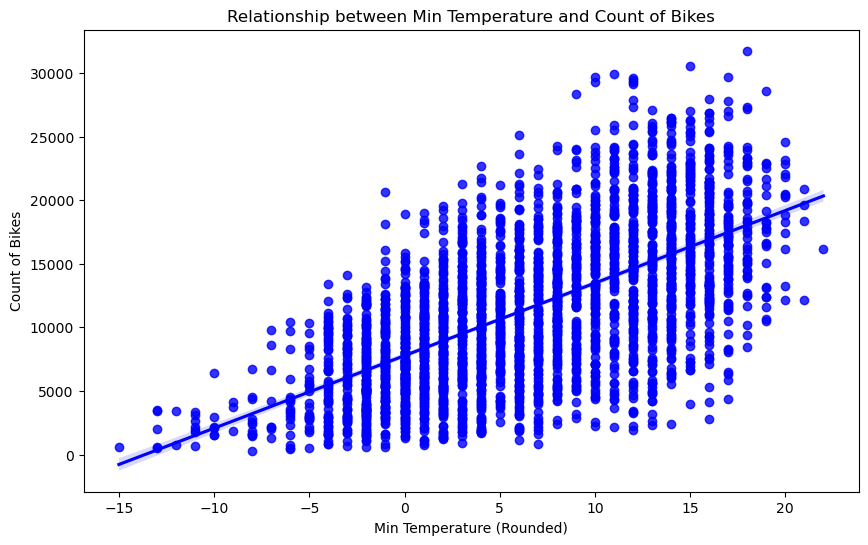

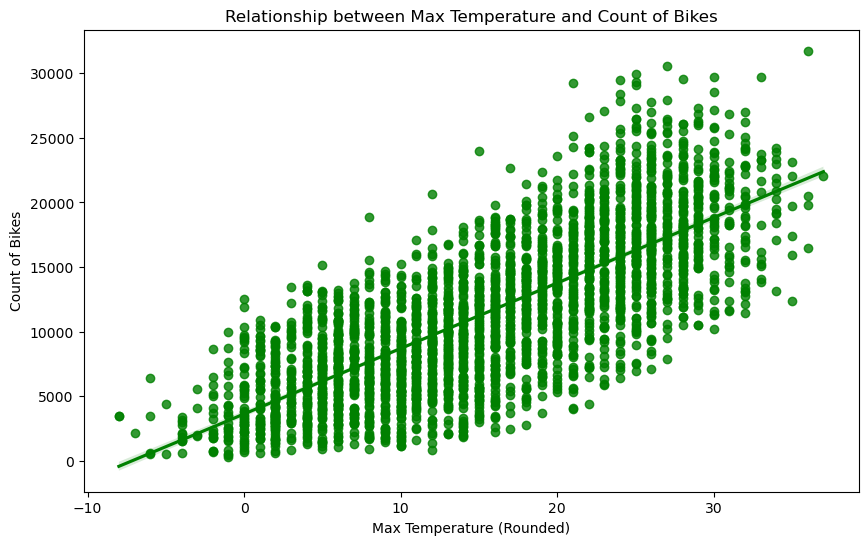

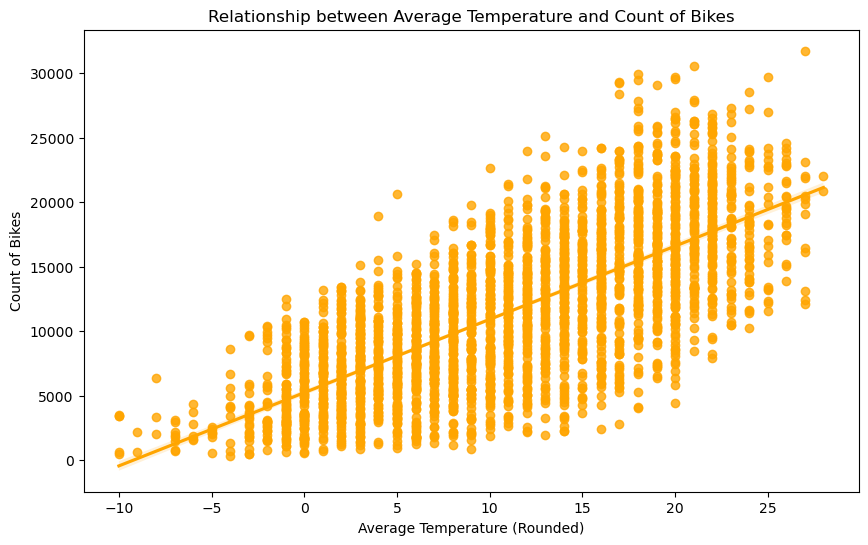

In [504]:
# Round the temperature values to the nearest integer
df_munich_all_locations['min.temp_rounded'] = df_munich_all_locations['min.temp'].round()
df_munich_all_locations['max.temp_rounded'] = df_munich_all_locations['max.temp'].round()
df_munich_all_locations['average_temp'] = ((df_munich_all_locations['min.temp'] + df_munich_all_locations['max.temp']) / 2).round()

# Plot 1: Relationship between rounded min.temp and count of bikes
plt.figure(figsize=(10, 6))
sns.regplot(x='min.temp_rounded', y='gesamt', data=df_munich_all_locations, color='blue')
plt.xlabel('Min Temperature (Rounded)')
plt.ylabel('Count of Bikes')
plt.title('Relationship between Min Temperature and Count of Bikes')
plt.show()

# Plot 2: Relationship between rounded max.temp and count of bikes
plt.figure(figsize=(10, 6))
sns.regplot(x='max.temp_rounded', y='gesamt', data=df_munich_all_locations, color='green')
plt.xlabel('Max Temperature (Rounded)')
plt.ylabel('Count of Bikes')
plt.title('Relationship between Max Temperature and Count of Bikes')
plt.show()

# Plot 3: Relationship between rounded average temperature and count of bikes
plt.figure(figsize=(10, 6))
sns.regplot(x='average_temp', y='gesamt', data=df_munich_all_locations, color='orange')
plt.xlabel('Average Temperature (Rounded)')
plt.ylabel('Count of Bikes')
plt.title('Relationship between Average Temperature and Count of Bikes')
plt.show()


## Rain and Bike Count
In contrast, when we examine the relationship between bike counts and rainfall, we see a linear decrease as the volume of precipitation increases. Unsurprisingly, bike counts are highest on rain-free days. Rain appears to be a significant deterrent to cycling.

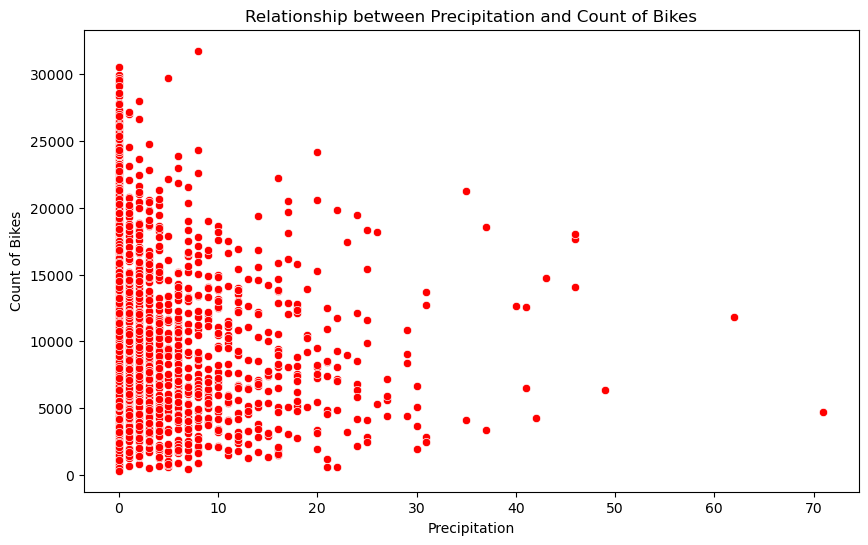

In [505]:
df_munich_all_locations['rain_rounded'] = df_munich_all_locations['niederschlag'].round()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rain_rounded', y='gesamt', data=df_munich_all_locations, color='red')
plt.xlabel('Precipitation')
plt.ylabel('Count of Bikes')
plt.title('Relationship between Precipitation and Count of Bikes')
plt.show()


### Weather’s Influence

Overall, these findings suggest that people in general are more inclined to avoid cycling in bad weather, primarily when it rains, rather than being significantly encouraged by good weather. In other words, unfavorable weather conditions seem to dissuade cycling, while favorable conditions do not lead to a substantial increase in bike usage. This underscores the significant influence of weather on bike count records.

## Analyzing Trends in Time Series Data

### Techniques to identify trends, suitable for different scenarios:
- **Moving average**: Useful for smoothing short-term fluctuations and highlighting longer-term trends by averaging data points over a specific period.
- **Exponential smoothing**: Similar to Moving Average but gives more weight to recent observations, making it responsive to changes in trends.
- **Decomposition**: This comprehensive method breaks down the time series into trend, seasonality, and noise components. It’s particularly effective for data with clear seasonal patterns.
- **ARIMA Models**: Standing for AutoRegressive Integrated Moving Average, ARIMA is a sophisticated method that models time series data based on its own lagged values (autoregressive), the differencing of raw observations (integrated), and a moving average model.

**_Given the characteristics of our dataset, Decomposition is a suitable choice for initial analysis._**

This method provides a solid foundation for understanding the basic structure of our time series before moving on to forecasting models.

<Figure size 1600x800 with 0 Axes>

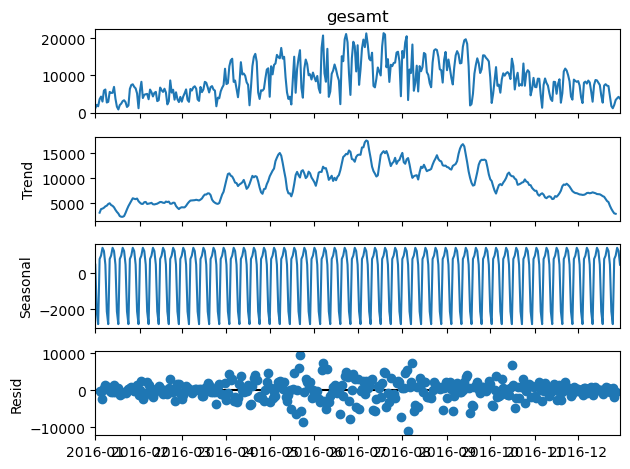

In [506]:
# Decomposing the time series into trend, seasonal and residual components
## But only for 2016, in order to be able to see the data
subset_df = df_munich_all_locations.iloc[:365]

decomposition = sm.tsa.seasonal_decompose(subset_df['gesamt'], model='additive')

# Plotting the decomposition
plt.figure(figsize=(16, 8))
decomposition.plot()
plt.show()



# ### 
# The analysis of our sales data begins with a decomposition, 
# followed by calculating a 7-day moving average.
# ** Decomposition Graph **
# 3 components:
# - Trend, which shows the overall direction in which our sales data is moving over time.
# - Seasonal, illustrates any repeating patterns or cycles in the sales data, often tied to specific times of the year.
# - Residual, represents the ‘noise’ in the data after removing the trend and seasonal components.
# ###

### 7-Day Moving Average Graph:

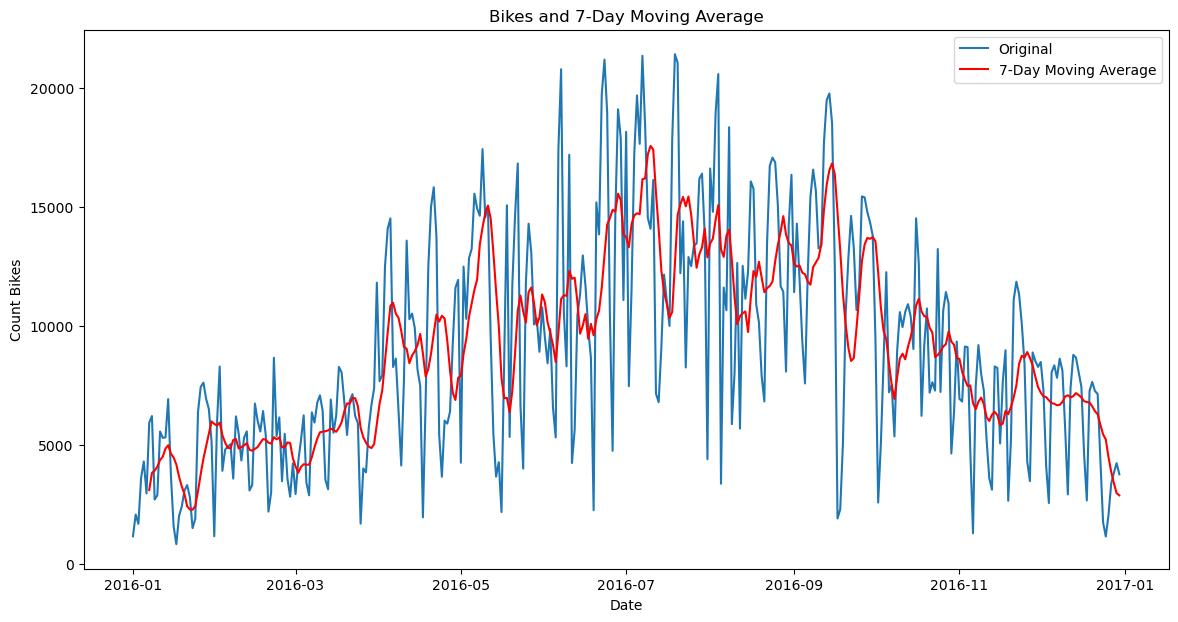

In [526]:
# Create a copy of the subset_df DataFrame
subset_df_copy = subset_df.copy()

# Calculate the 7-day moving average for the sales data
subset_df_copy['7-Day MA'] = subset_df_copy['gesamt'].rolling(window=7).mean()

# Plotting the original sales data with the 7-day moving average
plt.figure(figsize=(14, 7))
plt.plot(subset_df_copy['gesamt'], label='Original')
plt.plot(subset_df_copy['7-Day MA'], color='red', label='7-Day Moving Average')
plt.title('Bikes and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count Bikes')
plt.legend()
plt.show()


Visualizations are foundational steps in time series analysis, helping us gain a deeper understanding of the data’s behavior and setting the stage for more complex analyses and forecasting.

### 30-Day Moving Average Graph:

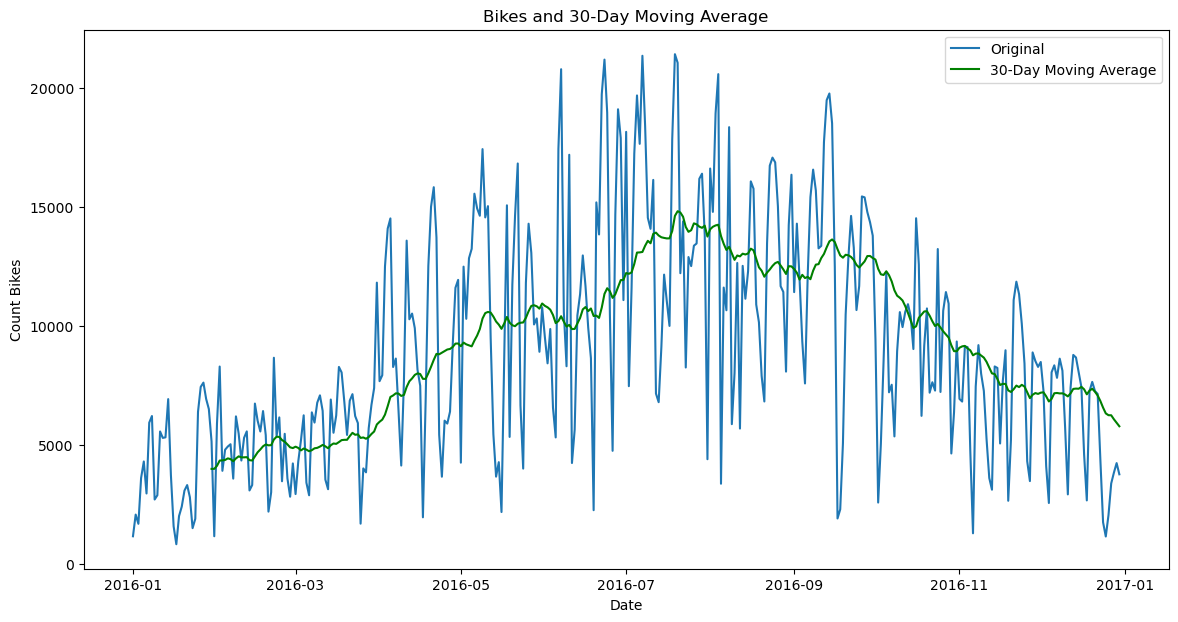

In [527]:
# Create a copy of the subset_df DataFrame
subset_df_copy = subset_df.copy()

# Calculate the 30-day moving average for the bikes data
subset_df_copy['30-Day MA'] = subset_df_copy['gesamt'].rolling(window=30).mean()

# Plotting the original bikes data with the 30-day moving average
plt.figure(figsize=(14, 7))
plt.plot(subset_df_copy['gesamt'], label='Original')
plt.plot(subset_df_copy['30-Day MA'], color='green', label='30-Day Moving Average')
plt.title('Bikes and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count Bikes')
plt.legend()
plt.show()


### Now, the same process but for all dates

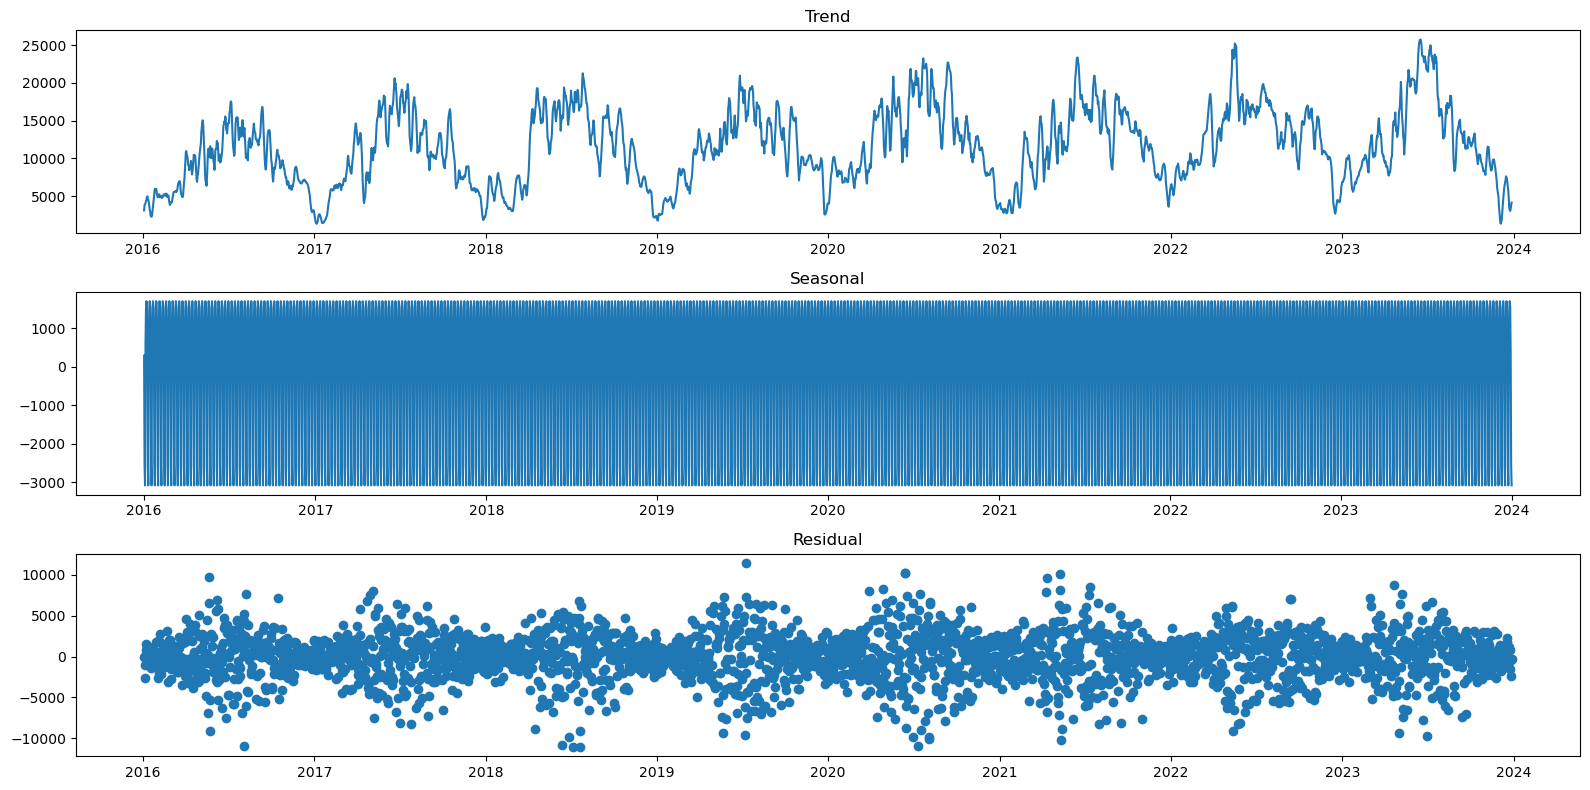

In [509]:
# Decomposing the time series into trend, seasonal and residual components

decomposition = sm.tsa.seasonal_decompose(df_munich_all_locations['gesamt'], model='additive')

## For Later
decomposition_rain = sm.tsa.seasonal_decompose(df_munich_all_locations['niederschlag'], model='additive')

# Plotting the decomposition
plt.figure(figsize=(16, 8))

# Plot Trend
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend)
plt.title('Trend')

# Plot Seasonal
plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

# Plot Residual
plt.subplot(3, 1, 3)
plt.scatter(decomposition.resid.index, decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()
# ### 
# The analysis of our sales data begins with a decomposition, 
# followed by calculating a 7-day moving average.
# ** Decomposition Graph **
# 3 components:
# - Trend, which shows the overall direction in which our sales data is moving over time.
# - Seasonal, illustrates any repeating patterns or cycles in the sales data, often tied to specific times of the year.
# - Residual, represents the ‘noise’ in the data after removing the trend and seasonal components.
# ###

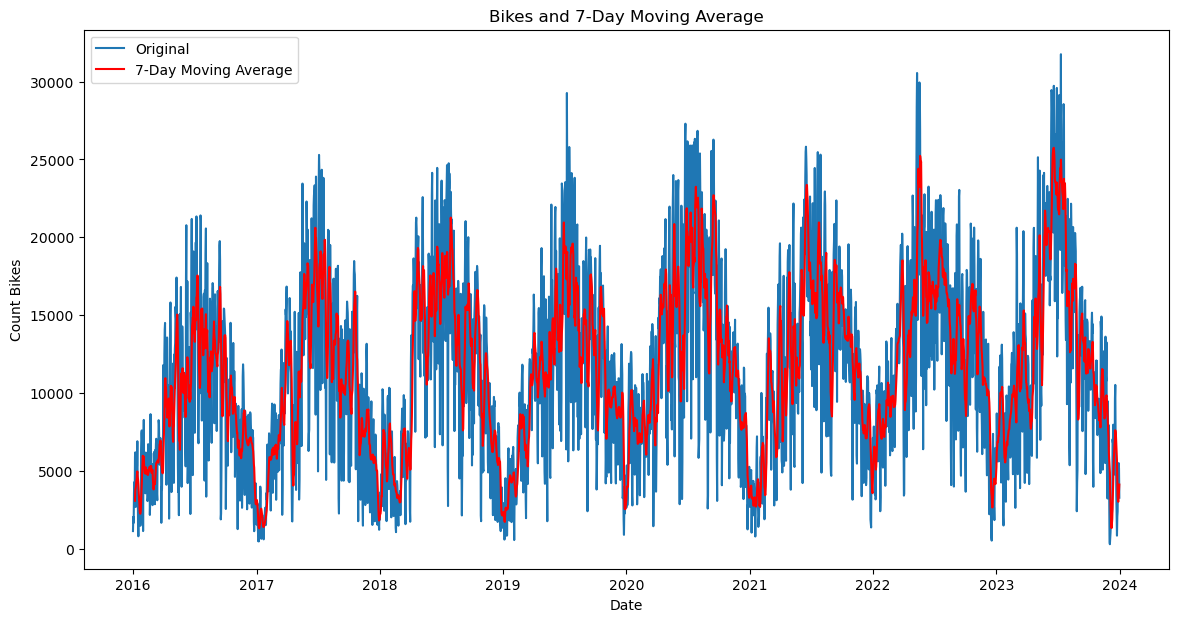

In [510]:
# Rolling - Calculating a 7-day moving average for the sales data
df_munich_all_locations['7-Day MA'] = df_munich_all_locations['gesamt'].rolling(window=7).mean()

# Plotting the original sales data with the 7-day moving average
plt.figure(figsize=(14, 7))
plt.plot(df_munich_all_locations['gesamt'], label='Original')
plt.plot(df_munich_all_locations['7-Day MA'], color='red', label='7-Day Moving Average')
plt.title('Bikes and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count Bikes')
plt.legend()
plt.show()

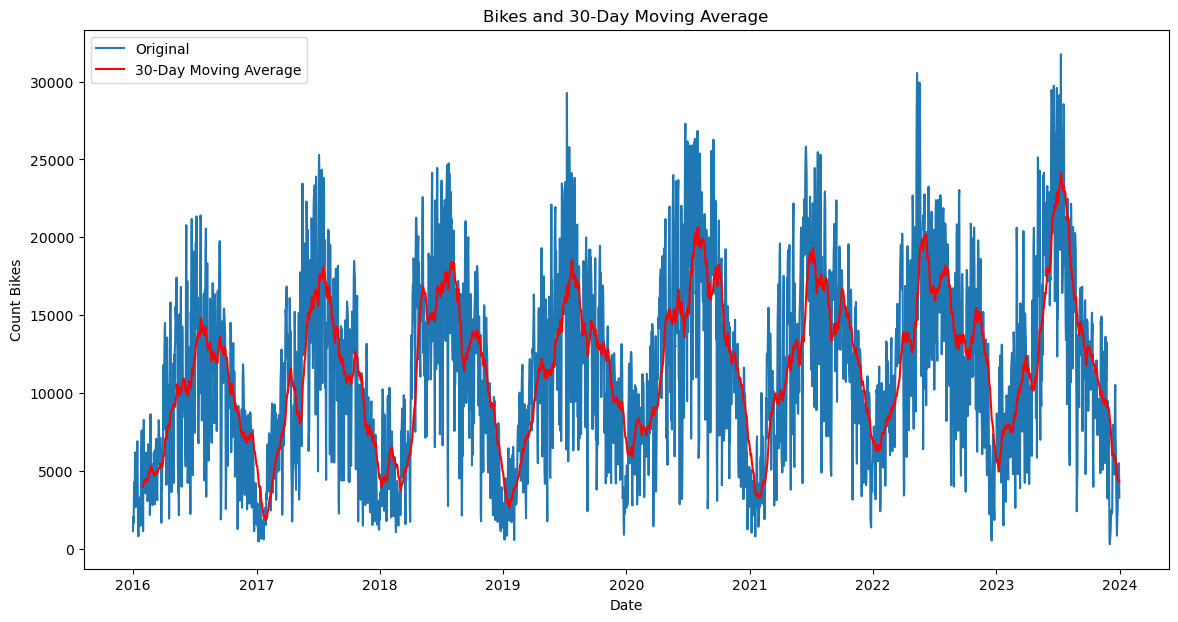

In [511]:
# Rolling - Calculating a 30-day moving average for the bikes data
df_munich_all_locations['30-Day MA'] = df_munich_all_locations['gesamt'].rolling(window=30).mean()

# Plotting the original bikes data with the 30-day moving average
## -> longer moving average provides an even smoother view of the sales trend over a month, further reducing the impact of short-term fluctuations.
plt.figure(figsize=(14, 7))
plt.plot(df_munich_all_locations['gesamt'], label='Original')
plt.plot(df_munich_all_locations['30-Day MA'], color='red', label='30-Day Moving Average')
plt.title('Bikes and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Count Bikes')
plt.legend()
plt.show()

### Checking Temperatures

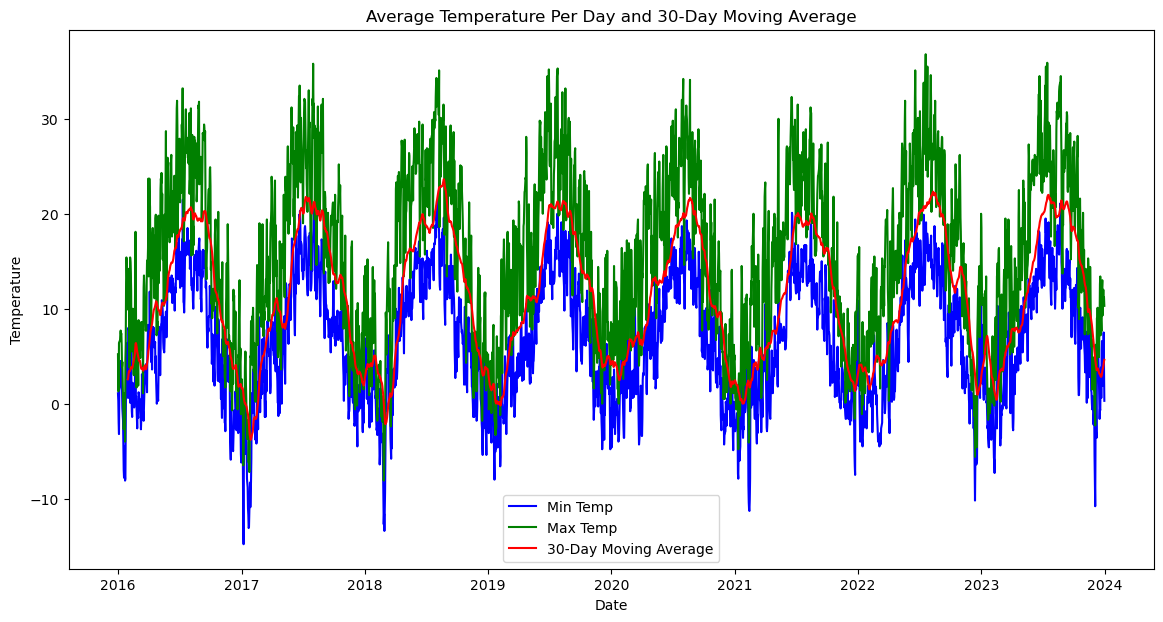

In [512]:
# Calculate the average temperature per day
df_munich_all_locations['avg.temp'] = (df_munich_all_locations['min.temp'] + df_munich_all_locations['max.temp']) / 2

# Calculate the 30-day moving average of the average temperature per day
df_munich_all_locations['30-Day Avg Temp MA'] = df_munich_all_locations['avg.temp'].rolling(window=30).mean()

# Plotting the original average temperature per day and the 30-day moving average
plt.figure(figsize=(14, 7))

plt.plot(df_munich_all_locations['min.temp'], label='Min Temp', color='blue')
plt.plot(df_munich_all_locations['max.temp'], label='Max Temp', color='green')
# plt.plot(df_munich_all_locations['avg.temp'], label='Average Temp Per Day', color='black')
plt.plot(df_munich_all_locations['30-Day Avg Temp MA'], color='red', label='30-Day Moving Average')
plt.title('Average Temperature Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

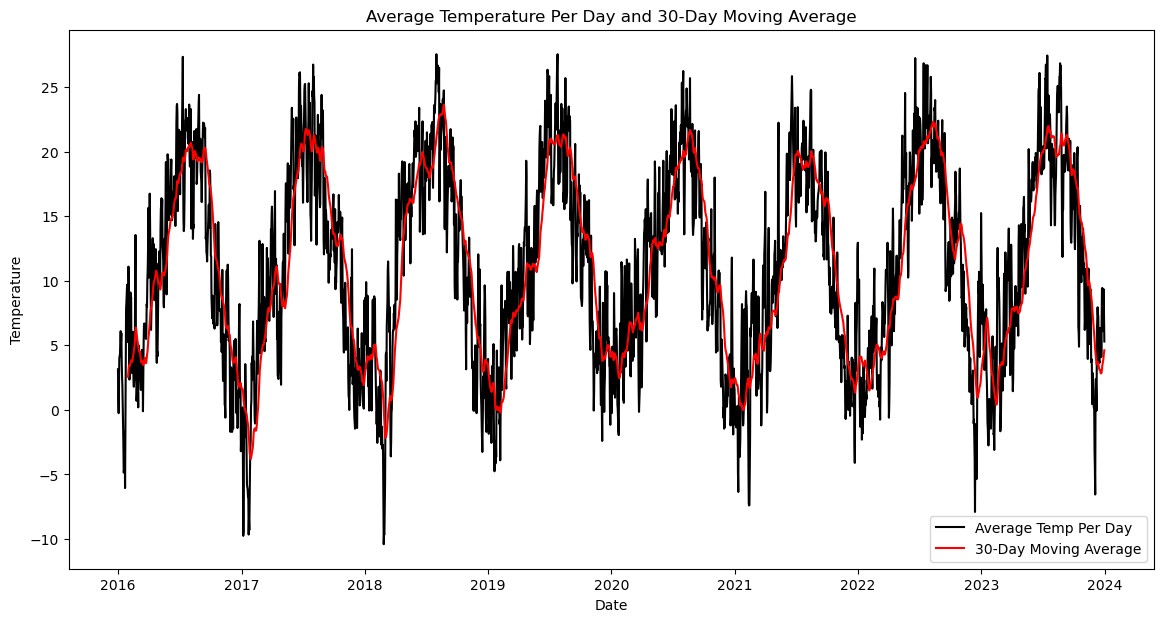

In [513]:
# Calculate the average temperature per day
df_munich_all_locations['avg.temp'] = (df_munich_all_locations['min.temp'] + df_munich_all_locations['max.temp']) / 2

# Calculate the 30-day moving average of the average temperature per day
df_munich_all_locations['30-Day Avg Temp MA'] = df_munich_all_locations['avg.temp'].rolling(window=30).mean()

# Plotting the original average temperature per day and the 30-day moving average
plt.figure(figsize=(14, 7))
plt.plot(df_munich_all_locations['avg.temp'], label='Average Temp Per Day', color='black')
plt.plot(df_munich_all_locations['30-Day Avg Temp MA'], color='red', label='30-Day Moving Average')
plt.title('Average Temperature Per Day and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [514]:
## test
def adfTest(series):
    
    result = adfuller(series.dropna(), autolag = 'AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4], index = labels)

    for key,val in result[4].items():
        out[f'critical value ({key})'] = val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

### Checking Precipitation

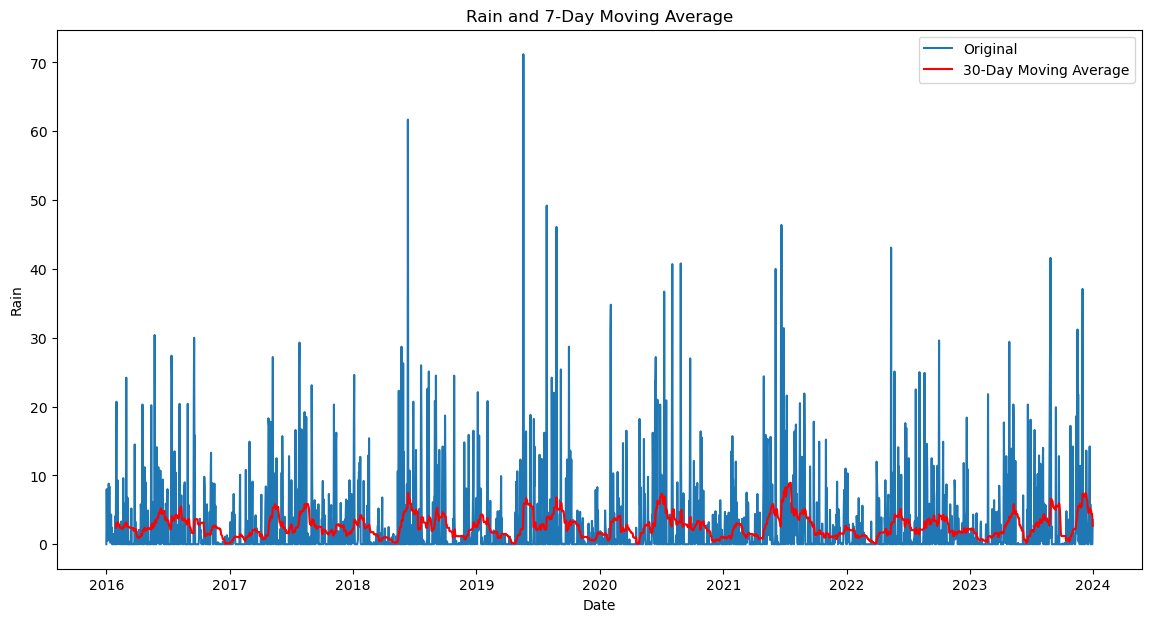

In [515]:
# Rolling - Calculating a 7-day moving average for the sales data
df_munich_all_locations['30-Day MA Rain'] = df_munich_all_locations['niederschlag'].rolling(window=30).mean()

# Plotting the original sales data with the 7-day moving average
plt.figure(figsize=(14, 7))
plt.plot(df_munich_all_locations['niederschlag'], label='Original')
plt.plot(df_munich_all_locations['30-Day MA Rain'], color='red', label='30-Day Moving Average')
plt.title('Rain and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend()
plt.show()

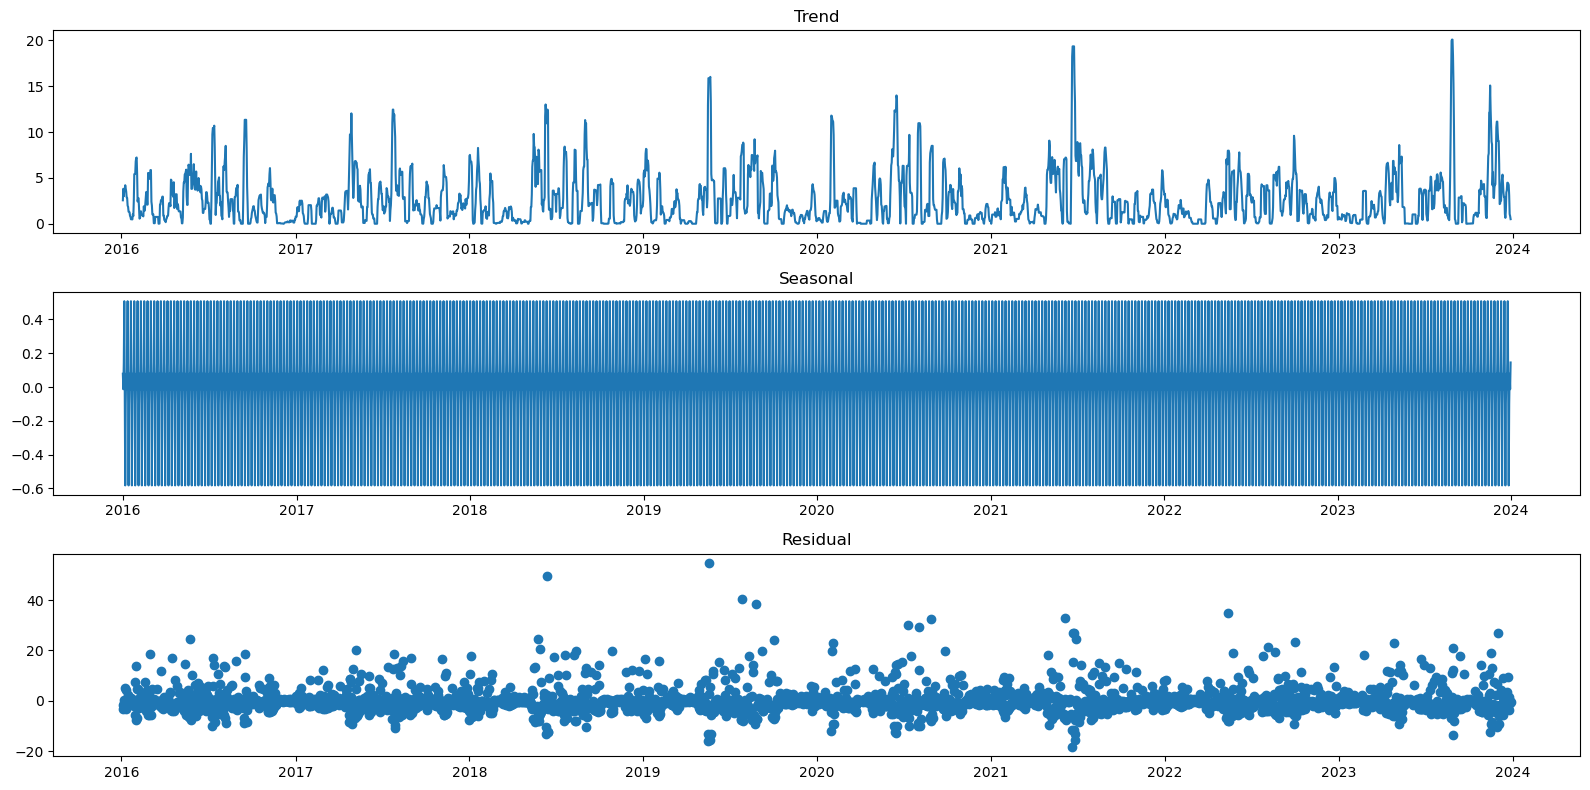

In [516]:
# Plotting the decomposition
plt.figure(figsize=(16, 8))

# Plot Trend
plt.subplot(3, 1, 1)
plt.plot(decomposition_rain.trend)
plt.title('Trend')

# Plot Seasonal
plt.subplot(3, 1, 2)
plt.plot(decomposition_rain.seasonal)
plt.title('Seasonal')

# Plot Residual
plt.subplot(3, 1, 3)
plt.scatter(decomposition_rain.resid.index, decomposition_rain.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()
# ### 
# The analysis of our sales data begins with a decomposition, 
# followed by calculating a 7-day moving average.
# ** Decomposition Graph **
# 3 components:
# - Trend, which shows the overall direction in which our sales data is moving over time.
# - Seasonal, illustrates any repeating patterns or cycles in the sales data, often tied to specific times of the year.
# - Residual, represents the ‘noise’ in the data after removing the trend and seasonal components.
# ###